<a href="https://colab.research.google.com/github/rahatrizvirahman/Finetune-LLAMA-2/blob/main/Finetune_LLAMA_2_Bangla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning LLama 2 on Bangla Dataset


In [1]:
# # Set up Python environment
# !pip install -r requirements.txt
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 13.0 MB/s eta 0:00:00


In [2]:
!pip install datasets==2.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.5 MB/s eta 0:00:00


In [3]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.3 MB/s eta 0:00:00


In [4]:
!pip install accelerate

In [5]:
!pip install trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 6.2 MB/s eta 0:00:00


In [6]:
!pip install evaluate
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 962.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=0bbd11f896def3e179ec3b692848499de2585720d2cbd61733a8cb51c5380fdd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [7]:
!pip install accelerate

In [8]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-nhrdiyfa
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-nhrdiyfa
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=3810bf054ec61824cbfa62c8277fcba6169616bf99ea178e0f2ce1d067d1f1c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_906_g_/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=4e0ee8c0ab4f6e86873a6bc58c07d841312a57d

In [9]:
# Import libraries
import argparse
import bitsandbytes as bnb
from datasets import load_dataset, Dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments, IntervalStrategy, EarlyStoppingCallback
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import time
import evaluate
import random
import pandas as pd
from normalizer import normalize
from sklearn.model_selection import train_test_split

import re




In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Reproducibility
random_state=123
seed = 42
set_seed(seed)

## Load Model Tokenizer

In [12]:
model_name = "meta-llama/Llama-2-7b-hf"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Load Dataset

In [28]:
!tar -xvf  '/content/drive/MyDrive/BanglaBERT Pretraining Dataset/Bangla2B+.tar.bz2' -C '/content/BanglaBERT-Extracted'


Bangla2B+/
Bangla2B+/README.md
Bangla2B+/shards/
Bangla2B+/shards/0.txt
Bangla2B+/shards/1302428.txt
Bangla2B+/shards/1953642.txt
Bangla2B+/shards/2604856.txt
Bangla2B+/shards/3256070.txt
Bangla2B+/shards/3907284.txt
Bangla2B+/shards/4558498.txt
Bangla2B+/shards/5209712.txt
Bangla2B+/shards/5860926.txt
Bangla2B+/shards/651214.txt
Bangla2B+/shards/6512140.txt
Bangla2B+/shards/7163354.txt
Bangla2B+/shards/7814568.txt
Bangla2B+/shards/8465782.txt
Bangla2B+/shards/9116996.txt
Bangla2B+/shards/9768210.txt


In [30]:
import os
size = os.path.getsize('/content/BanglaBERT-Extracted/Bangla2B+/shards/0.txt')
# size = os.path.getsize('/content/BanglaBERT-Extracted/Bangla2B+/shards/1953642.txt')
size = size/1e9

print(f'dataset size: {size}GB')

dataset size: 1.826581704GB


In [33]:
file = open("/content/BanglaBERT-Extracted/Bangla2B+/shards/0.txt", mode="r")

texts = file.read()

file.close()

In [34]:
print(len(texts))
print(texts[:1000])

709325504
আফগান কোচিং সেন্টারে হামলার দায় স্বীকার আইএস'র
আফগানিস্তানের রাজধানী কাবুলে একটি কোচিং সেন্টারে বুধবারের আত্মঘাতী বোমা হামলার দায় স্বীকার করেছে ইসলামিক স্টেট (আইএস)।
জঙ্গি গোষ্ঠীটি বৃহস্পতিবার তাদের আমাক বার্তা সংস্থায় এ দায় স্বীকার করে।
তবে এর সপক্ষে তারা কোনো প্রমাণ দেয়নি।
হমলাকারী আত্মঘাতী বেল্ট পরে ছিল বলে জানিয়েছে আমাক।
কোচিং সেন্টারে ওই হামলায় আফগান কর্তৃপক্ষ বৃহস্পতিবার ৩৪ জন নিহত এবং ৫৬ জন আহত হওয়ার কথা জানায়।
প্রথমে ৪৮ জন নিহত হওয়ার কথা বলা হলেও পরে তা সংশোধন করে ৩৪ জনে নামিয়ে আনা হয়েছে এবং আহতের সংখ্যাও সংশোধন করা হয়েছে বলে জানান স্বাস্থ্য মন্ত্রণালয়ের কর্মকর্তারা।
পুলিশ জানায়, পশ্চিম কাবুলের শিয়া হাজারা সম্প্রদায় অধ্যুষিত এলাকার ওই কোচিং সেন্টারটিতে নিয়মিত ক্লাস চলার সময়ে এক আত্মঘাতী বোমা হামলাকারী হেঁটে সেখানে প্রবেশ করে এবং শরীরে বাঁধা বিস্ফোরক বেল্টের বিস্ফোরণ ঘটায়।
নিহতদের মধে বেশিরভাগই তরুণ।
তারা বিশ্ববিদ্যালয়ে ভর্তি পরীক্ষায় অংশ নেওয়ার প্রস্তুতি নিতে মাবৌদ একাডেমি নামের ওই কোচিং সেন্টারে ক্লাস করছিল।

পাকিস্তানে মাজারে বোমায় নিহতের সংখ

In [35]:
articles = re.split(r'\n(\n)+', texts)
articles[:5]

["আফগান কোচিং সেন্টারে হামলার দায় স্বীকার আইএস'র\nআফগানিস্তানের রাজধানী কাবুলে একটি কোচিং সেন্টারে বুধবারের আত্মঘাতী বোমা হামলার দায় স্বীকার করেছে ইসলামিক স্টেট (আইএস)।\nজঙ্গি গোষ্ঠীটি বৃহস্পতিবার তাদের আমাক বার্তা সংস্থায় এ দায় স্বীকার করে।\nতবে এর সপক্ষে তারা কোনো প্রমাণ দেয়নি।\nহমলাকারী আত্মঘাতী বেল্ট পরে ছিল বলে জানিয়েছে আমাক।\nকোচিং সেন্টারে ওই হামলায় আফগান কর্তৃপক্ষ বৃহস্পতিবার ৩৪ জন নিহত এবং ৫৬ জন আহত হওয়ার কথা জানায়।\nপ্রথমে ৪৮ জন নিহত হওয়ার কথা বলা হলেও পরে তা সংশোধন করে ৩৪ জনে নামিয়ে আনা হয়েছে এবং আহতের সংখ্যাও সংশোধন করা হয়েছে বলে জানান স্বাস্থ্য মন্ত্রণালয়ের কর্মকর্তারা।\nপুলিশ জানায়, পশ্চিম কাবুলের শিয়া হাজারা সম্প্রদায় অধ্যুষিত এলাকার ওই কোচিং সেন্টারটিতে নিয়মিত ক্লাস চলার সময়ে এক আত্মঘাতী বোমা হামলাকারী হেঁটে সেখানে প্রবেশ করে এবং শরীরে বাঁধা বিস্ফোরক বেল্টের বিস্ফোরণ ঘটায়।\nনিহতদের মধে বেশিরভাগই তরুণ।\nতারা বিশ্ববিদ্যালয়ে ভর্তি পরীক্ষায় অংশ নেওয়ার প্রস্তুতি নিতে মাবৌদ একাডেমি নামের ওই কোচিং সেন্টারে ক্লাস করছিল।",
 '\n',
 "পাকিস্তানে মাজারে বোমায়

In [36]:
articles = list(filter(lambda x: x!='' and x!='\n', articles))

articles[:5]

["আফগান কোচিং সেন্টারে হামলার দায় স্বীকার আইএস'র\nআফগানিস্তানের রাজধানী কাবুলে একটি কোচিং সেন্টারে বুধবারের আত্মঘাতী বোমা হামলার দায় স্বীকার করেছে ইসলামিক স্টেট (আইএস)।\nজঙ্গি গোষ্ঠীটি বৃহস্পতিবার তাদের আমাক বার্তা সংস্থায় এ দায় স্বীকার করে।\nতবে এর সপক্ষে তারা কোনো প্রমাণ দেয়নি।\nহমলাকারী আত্মঘাতী বেল্ট পরে ছিল বলে জানিয়েছে আমাক।\nকোচিং সেন্টারে ওই হামলায় আফগান কর্তৃপক্ষ বৃহস্পতিবার ৩৪ জন নিহত এবং ৫৬ জন আহত হওয়ার কথা জানায়।\nপ্রথমে ৪৮ জন নিহত হওয়ার কথা বলা হলেও পরে তা সংশোধন করে ৩৪ জনে নামিয়ে আনা হয়েছে এবং আহতের সংখ্যাও সংশোধন করা হয়েছে বলে জানান স্বাস্থ্য মন্ত্রণালয়ের কর্মকর্তারা।\nপুলিশ জানায়, পশ্চিম কাবুলের শিয়া হাজারা সম্প্রদায় অধ্যুষিত এলাকার ওই কোচিং সেন্টারটিতে নিয়মিত ক্লাস চলার সময়ে এক আত্মঘাতী বোমা হামলাকারী হেঁটে সেখানে প্রবেশ করে এবং শরীরে বাঁধা বিস্ফোরক বেল্টের বিস্ফোরণ ঘটায়।\nনিহতদের মধে বেশিরভাগই তরুণ।\nতারা বিশ্ববিদ্যালয়ে ভর্তি পরীক্ষায় অংশ নেওয়ার প্রস্তুতি নিতে মাবৌদ একাডেমি নামের ওই কোচিং সেন্টারে ক্লাস করছিল।",
 "পাকিস্তানে মাজারে বোমায় নিহতের

In [17]:
# file = open("/content/BanglaBERT-extracted/Bangla2B+/shards/0.txt", mode="r")

# lines = file.readlines()
# print(len(lines))
# print(lines[:10])

# file.close()

9803850
["আফগান কোচিং সেন্টারে হামলার দায় স্বীকার আইএস'র\n", 'আফগানিস্তানের রাজধানী কাবুলে একটি কোচিং সেন্টারে বুধবারের আত্মঘাতী বোমা হামলার দায় স্বীকার করেছে ইসলামিক স্টেট (আইএস)।\n', 'জঙ্গি গোষ্ঠীটি বৃহস্পতিবার তাদের আমাক বার্তা সংস্থায় এ দায় স্বীকার করে।\n', 'তবে এর সপক্ষে তারা কোনো প্রমাণ দেয়নি।\n', 'হমলাকারী আত্মঘাতী বেল্ট পরে ছিল বলে জানিয়েছে আমাক।\n', 'কোচিং সেন্টারে ওই হামলায় আফগান কর্তৃপক্ষ বৃহস্পতিবার ৩৪ জন নিহত এবং ৫৬ জন আহত হওয়ার কথা জানায়।\n', 'প্রথমে ৪৮ জন নিহত হওয়ার কথা বলা হলেও পরে তা সংশোধন করে ৩৪ জনে নামিয়ে আনা হয়েছে এবং আহতের সংখ্যাও সংশোধন করা হয়েছে বলে জানান স্বাস্থ্য মন্ত্রণালয়ের কর্মকর্তারা।\n', 'পুলিশ জানায়, পশ্চিম কাবুলের শিয়া হাজারা সম্প্রদায় অধ্যুষিত এলাকার ওই কোচিং সেন্টারটিতে নিয়মিত ক্লাস চলার সময়ে এক আত্মঘাতী বোমা হামলাকারী হেঁটে সেখানে প্রবেশ করে এবং শরীরে বাঁধা বিস্ফোরক বেল্টের বিস্ফোরণ ঘটায়।\n', 'নিহতদের মধে বেশিরভাগই তরুণ।\n', 'তারা বিশ্ববিদ্যালয়ে ভর্তি পরীক্ষায় অংশ নেওয়ার প্রস্তুতি নিতে মাবৌদ একাডেমি নামের ওই কোচিং সেন্টারে ক্লা

In [ ]:
# train_df = pd.read_parquet('/content/drive/MyDrive/Rahat/Dataset/CulturaX-Bangla/bn_part_00000.parquet', engine='pyarrow')

In [ ]:
# train_df.head()

,text,timestamp,url,source
0,করোনা মোকাবেলায় নিজ নিজ কর্মস্থলে যথাযথভাবে স...,2021/06/18 05:29:09,https://www.suprovatbogura.com/%E0%A6%95%E0%A6...,mC4
1,গাজীপুরে কিশোরী গণধর্ষণ মামলার প্রধান আসামী গ্...,2021/12/02 06:43:30,http://dhansirinews.com/2020/10/10/%E0%A6%97%E...,mC4
2,অনুপ্রবেশকারীদের হটিয়ে শরণার্থী-উদ্বাস্তুদের ...,2021/12/07 03:06:25,https://ebangla.org/4615/%E0%A6%85%E0%A6%A8%E0...,mC4
3,কানাইঘাটের সার্বিক বন্যা পরিস্থিতির অবনতি : নৌ...,2022/07/01 04:39:29,https://www.crimesylhet.com/2022/05/17/%E0%A6%...,mC4
4,আবারও মিন্নির জামিন আবেদন নামঞ্জুর করলেন আদালত...,2022/05/25 08:02:16,https://dhansirinews.com/%E0%A6%86%E0%A6%AC%E0...,mC4


In [ ]:
# len(train_df)

690922

In [ ]:
# train_df.loc[0]["text"]

"করোনা মোকাবেলায় নিজ নিজ কর্মস্থলে যথাযথভাবে স্বাস্থ্যবিধি মেনে চলার আহ্বান প্রধানমন্ত্রীর | Suprovat Bogura\nপ্রচ্ছদ কৃষি সংবাদ করোনা মোকাবেলায় নিজ নিজ কর্মস্থলে যথাযথভাবে স্বাস্থ্যবিধি মেনে চলার আহ্বান প্রধানমন্ত্রীর\nকরোনা মোকাবেলায় নিজ নিজ কর্মস্থলে যথাযথভাবে স্বাস্থ্যবিধি মেনে চলার আহ্বান প্রধানমন্ত্রীর\nকরোনা মোকাবেলায় নিজ নিজ কর্মস্থলে যথাযথভাবে স্বাস্থ্যবিধি মেনে চলার আহ্বান প্রধানমন্ত্রীর। ছবি-সংগৃহীত\nসুপ্রভাত বগুড়া (জাতীয়): প্রধানমন্ত্রী শেখ হাসিনা সকলকে করোন ভাইরাস থেকে নিজেদের সুরক্ষিত রাখতে নিজ নিজ কর্মস্থলে যথাযথভাবে স্বাস্থ্যবিধি মেনে চলার আহ্বান জানিয়ে বলেছেন, জনগণের কল্যাণের কথাই তাঁর সরকার সবচেয়ে বেশি চিন্তা করছে।\nতিনি বলেন, 'সকলকে স্ব-স্ব স্বাস্থ্য সুরক্ষিত রেখেই স্ব-স্ব কর্মস্থলে কাজ করে যেতে হবে। দেশের মানুষ যাতে কষ্ট না পায় কেননা তাঁদের কথাই আমরা বেশি চিন্তা করি। সবাই ভাল থাকেন, সুস্থ থাকেন, সেটাই কামনা করি।'\nমঙ্গলবার (৩ মে) প্রধানমন্ত্রী শেখ হাসিনা জাতীয় অর্থনৈতিক পরিষদের নির্বাহী কমিটির (একনেক) সভায় একথা বলেন। রাজধানীর শেরেবাংলা নগরের এনইসি সম্মেলন

In [46]:
train_df = pd.DataFrame(data={'text':articles})
train_df.head()

,text
0,আফগান কোচিং সেন্টারে হামলার দায় স্বীকার আইএস'...
1,পাকিস্তানে মাজারে বোমায় নিহতের সংখ্যা বেড়ে ৫...
2,সে কিভাবে রিগামের সাথে সম্পর্কিত? How is he re...
3,"অক্টোবর মাসে, জোডি একজন অবাপ্তাইজিত প্রকাশক হয..."
4,Although the stock exchanges stopped this proc...


In [38]:
def get_normalized_sample(sample):
  sample["text"] = normalize(
      sample["text"],
      # unicode_norm="NFKC",          # type of unicode normalization (default "NFKC")
      # punct_replacement=None,       # an optional string or callable for replacing the punctuations (default `None`, i.e. no replacement)
      # url_replacement=None,         # an optional string or callable for replacing the URLS (default `None`, i.e. no replacement)
      # emoji_replacement=None,       # an optional string or callable for replacing the emojis (default `None`, i.e. no replacement)
      # apply_unicode_norm_last=True  # whether to apply the unicode normalization before or after rule based replacements (default True)
  )

  return sample

In [51]:
train_df = train_df.apply(lambda x: get_normalized_sample(x), axis=1 )
# train_dataset = train_dataset.map(lambda x: get_normalized_sample(x) )

Map:   0%|          | 0/622104 [00:00<?, ? examples/s]

In [52]:
# # Check if there is any emtpy sample
# for i in range(len(train_df)):
#   if len(train_df.loc[i]["text"])==0:
#     print(train_df.loc[i])

In [55]:
tokenizer(train_df['text'][0])['input_ids']

[1,
 29871,
 227,
 169,
 137,
 227,
 169,
 174,
 31665,
 30445,
 30792,
 29871,
 30995,
 31864,
 227,
 169,
 157,
 30786,
 227,
 169,
 133,
 29871,
 31148,
 30932,
 30792,
 30655,
 227,
 169,
 162,
 30445,
 30653,
 30932,
 29871,
 31717,
 30445,
 31006,
 31055,
 30445,
 30653,
 29871,
 31204,
 30445,
 31218,
 31552,
 29871,
 31148,
 30655,
 30962,
 31595,
 30995,
 30445,
 30653,
 29871,
 227,
 169,
 137,
 227,
 169,
 138,
 227,
 169,
 146,
 31148,
 29915,
 30653,
 29871,
 227,
 169,
 137,
 227,
 169,
 174,
 31665,
 30445,
 30792,
 30786,
 31148,
 30655,
 31150,
 30445,
 30792,
 30932,
 30653,
 29871,
 30653,
 30445,
 31537,
 227,
 169,
 170,
 30445,
 30792,
 31595,
 29871,
 30995,
 30445,
 30962,
 31154,
 31055,
 30932,
 29871,
 227,
 169,
 146,
 30995,
 227,
 169,
 162,
 30786,
 29871,
 30995,
 31864,
 227,
 169,
 157,
 30786,
 227,
 169,
 133,
 29871,
 31148,
 30932,
 30792,
 30655,
 227,
 169,
 162,
 30445,
 30653,
 30932,
 29871,
 30962,
 31154,
 227,
 169,
 170,
 30962,
 30445,
 3

In [56]:
train_context_lengths = [len(tokenizer(input)['input_ids']) for input in tqdm(train_df['text'])]

  0%|          | 0/622104 [00:00<?, ?it/s]

In [57]:
train_context_lengths

[1218,
 1447,
 47,
 144,
 171,
 238,
 3245,
 1668,
 53,
 3794,
 76,
 13,
 95,
 71,
 5349,
 136,
 2564,
 4518,
 2635,
 1742,
 45,
 3561,
 1477,
 184,
 138,
 672,
 4744,
 254,
 19,
 156,
 77,
 11061,
 327,
 2684,
 145,
 151,
 56,
 2432,
 834,
 437,
 61,
 28,
 299,
 1279,
 1489,
 1352,
 70,
 1810,
 1459,
 196,
 111,
 39,
 82,
 199,
 175,
 719,
 65,
 523,
 109,
 265,
 276,
 593,
 248,
 315,
 1534,
 1042,
 62,
 161,
 686,
 27,
 58,
 221,
 12,
 83,
 1405,
 1821,
 2213,
 8349,
 5493,
 2566,
 657,
 1019,
 3154,
 35,
 23426,
 346,
 2579,
 192,
 3581,
 313,
 354,
 1753,
 2121,
 1964,
 50,
 1357,
 105,
 2682,
 304,
 3413,
 96,
 1734,
 2314,
 591,
 1065,
 207,
 2387,
 43,
 14,
 310,
 2068,
 148,
 75,
 1220,
 3334,
 195,
 1789,
 2257,
 1998,
 56,
 138,
 2411,
 21,
 376,
 5895,
 21,
 216,
 2149,
 1489,
 699,
 8253,
 727,
 52,
 147,
 2304,
 174,
 2417,
 1389,
 548,
 1253,
 19,
 107,
 1438,
 14,
 67,
 2376,
 3674,
 136,
 18,
 1173,
 52,
 2210,
 104,
 219,
 364,
 288,
 3739,
 117,
 1198,
 61,
 4190,
 2

### Save context lengths

In [41]:
context_length_df = pd.DataFrame(data={"context_lengths":train_context_lengths})
context_length_df.to_csv("/content/drive/MyDrive/Rahat/Dataset/banglabert_file_0_articles_context_length_df.csv")

NameError: name 'train_context_lengths' is not defined

### Load saved context lengths
Use when "context_lenghth_df" is already saved

In [47]:
context_length_df= pd.read_csv("/content/drive/MyDrive/Rahat/Dataset/banglabert_file_0_articles_context_length_df.csv")

train_context_lengths = context_length_df["context_lengths"]

context_length_df.head()

,Unnamed: 0,context_lengths
0,0,1218
1,1,1447
2,2,47
3,3,144
4,4,171


In [43]:
len(train_context_lengths)

622104

In [44]:
print("Min length context: ", min(train_context_lengths))
print("Max length context: ", max(train_context_lengths))

Min length context:  5
Max length context:  727129


In [22]:

print("Total artilces with less than 4096 tokens is ", len(train_context_lengths[train_context_lengths<4096]))

Total artilces with less than 4096 tokens is  582551


In [23]:
valid_train_context_lengths =  train_context_lengths[train_context_lengths<4096]

(array([ 11.,  44., 100., ...,  22.,  23.,  36.]),
 array([   5.,    6.,    7., ..., 4093., 4094., 4095.]),
 <BarContainer object of 4090 artists>)

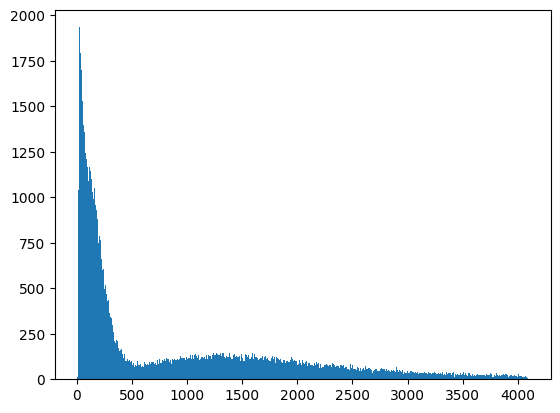

In [24]:
plt.hist(valid_train_context_lengths, bins=np.arange(min(valid_train_context_lengths), max(valid_train_context_lengths)+1))

### Remove Articles with more than 4096 tokens

In [54]:
train_context_lengths = np.array(train_context_lengths)

In [55]:
train_df = train_df.loc[train_context_lengths<4096]

train_dataset = Dataset.from_pandas(train_df)

len(train_dataset)

582551

In [56]:
del train_df

## Train, Test, Val split

In [61]:
splitted_dataset = train_dataset.train_test_split(test_size=0.2)

train_dataset = splitted_dataset["train"]
val_dataset =  splitted_dataset["test"]

del splitted_dataset

In [62]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [70]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )


# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset:str):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    # dataset = dataset.map(create_prompt_formats)#, batched=True)
    # dataset = dataset.apply(create_prompt_formats, axis=1)#, batched=True)

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["text"], # it was not needed for this dataset
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [71]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

To leverage the LoRa method, we need to wrap the model as a PeftModel.

To do this, we need to implement a [LoRa configuration](https://huggingface.co/docs/peft/conceptual_guides/lora):

In [18]:
def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

In [19]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()

    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [65]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

## Training

In [21]:
# Load model from HF with user's token and with bitsandbytes config
bnb_config = create_bnb_config()
model, tokenizer = load_model(model_name, bnb_config)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [22]:

model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [23]:
model.dtype

torch.float16

In [66]:
model.num_parameters()

6738415616

In [67]:
train_dataset

Dataset({
    features: ['text', '__index_level_0__'],
    num_rows: 466040
})

In [72]:
## Preprocess dataset
max_length = get_max_length(model)
train_dataset = preprocess_dataset(tokenizer, max_length, seed, train_dataset)

Found max lenth: 4096
Preprocessing dataset...


Map:   0%|          | 0/466040 [00:00<?, ? examples/s]

Filter:   0%|          | 0/466040 [00:00<?, ? examples/s]

In [75]:
val_dataset = preprocess_dataset(tokenizer, max_length, seed, val_dataset)

Preprocessing dataset...


Map:   0%|          | 0/116511 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116511 [00:00<?, ? examples/s]

In [ ]:
# nb_samples = 100
# random_indices = random.sample(range(len(val_dataset)), nb_samples)

# sample_val_dataset = val_dataset.select(random_indices)

# len(sample_val_dataset)

In [ ]:
print(train_dataset)

### Explore Transformed Dataset

In [76]:
# Generate random indices
nb_samples = 3
random_indices = random.sample(range(len(train_dataset)), nb_samples)
samples = []

for idx in random_indices:
    sample = train_dataset[idx]

    samples.append(sample)

# Create a DataFrame and display it
df = pd.DataFrame(samples)
df

,__index_level_0__,input_ids,attention_mask
0,5513,"[1, 29871, 31204, 30786, 31204, 31154, 30792, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,425430,"[1, 448, 1724, 437, 366, 2562, 29973, 448, 298...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,484616,"[1, 18927, 310, 670, 664, 1401, 919, 29879, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [77]:
def train(model, tokenizer, dataset, val_dataset, output_dir):
    # Apply preprocessing to the model to prepare it by
    # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # 2 - Using the prepare_model_for_kbit_training method from PEFT
    model = prepare_model_for_kbit_training(model)

    # Get lora module names
    modules = find_all_linear_names(model)

    # Create PEFT config for these modules and wrap the model to PEFT
    peft_config = create_peft_config(modules)
    model = get_peft_model(model, peft_config)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    args=TrainingArguments(
            output_dir= f"{output_dir}/outputs",
            evaluation_strategy = IntervalStrategy.STEPS,
            eval_steps = 200,  #evalute after each N steps
            save_total_limit = 2,
            save_steps=200,  # save model after each N steps
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            num_train_epochs=1,
            # max_steps=15,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=1,
            optim="paged_adamw_8bit",
            metric_for_best_model = 'eval_loss',
            # metric_for_best_model = 'perplexity',
            load_best_model_at_end = True  # Without this get this error : AssertionError: EarlyStoppingCallback requires load_best_model_at_end = True
        )


    # Training parameters
    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        args=args,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    model.config.use_cache = False  # re-enable for inference to speed up predictions for similar inputs

    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    do_train = True

    # Launch training
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    ###

    # Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()


output_dir = "/content/drive/MyDrive/Rahat/Finetuned_model/Llama2-BanglaBert/Model-Output"

train(model, tokenizer, train_dataset, val_dataset, output_dir)


all params: 3,580,366,848 || trainable params: 39,976,960 || trainable%: 1.1165604447022295
torch.float32 342364160 0.09562264833036462
torch.uint8 3238002688 0.9043773516696354
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## Merge Weights

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = "/content/drive/MyDrive/Rahat/Finetuned_model/Llama2-BanglaBert/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('/content/drive/MyDrive/Rahat/Finetuned/llama2-bangla-sentiment-analysis/final_merged_checkpoint/tokenizer_config.json',
 '/content/drive/MyDrive/Rahat/Finetuned/llama2-bangla-sentiment-analysis/final_merged_checkpoint/special_tokens_map.json',
 '/content/drive/MyDrive/Rahat/Finetuned/llama2-bangla-sentiment-analysis/final_merged_checkpoint/tokenizer.json')

#### Push model to Hugging Face Hub (Optional)

*To follow this part, make sure you logged in with a `Write` access token when you used the `huggingface-cli login` command.*

If you want to share your model with others, you can push your model and your token to the Hub, in a new repository.

In [ ]:
model.push_to_hub("llama2-fine-tuned-culturaX-bangla-file-0")

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rahat01/llama2-fine-tuned-bangla-sentNob/commit/dde4824e8242ac8f089d46228c911b19ce5e6f36', commit_message='Upload LlamaForCausalLM', commit_description='', oid='dde4824e8242ac8f089d46228c911b19ce5e6f36', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("llama2-fine-tuned-bangla-sentNob")


CommitInfo(commit_url='https://huggingface.co/rahat01/llama2-fine-tuned-bangla-sentNob/commit/d78c1e286eb76a88742503917b5816854a33336d', commit_message='Upload tokenizer', commit_description='', oid='d78c1e286eb76a88742503917b5816854a33336d', pr_url=None, pr_revision=None, pr_num=None)